In [2]:
import itertools
import os

import numpy as np
import pandas as pd
from plotnine import *

In [6]:
fuzzers = ['zest', 'bedivfuzz', 'blind']
subjects = ['ant', 'bcel', 'chocopy', 'closure', 'maven', 'nashorn', 'pngj', 'rhino', 'tomcat']
num_trials = 20
timeout = 180

results_base_dir = 'eval-fast-js-fixed'

In [7]:
def trial_df(fuzzer: str, subject: str, trial: int):
    df = pd.read_csv(
        os.path.join(results_base_dir, fuzzer, subject, f'trial-{trial}', 'plot_data'),
        skipinitialspace=True
    )

    # one datapoint per minute
    df = df.loc[np.linspace(0, len(df)-1, timeout, endpoint=True, dtype=np.int64)]
    df['time'] = range(1, timeout+1)
    df['trial'] = trial
    df['fuzzer'] = fuzzer
    df['subject'] = subject

    return df[['fuzzer', 'subject', 'trial', 'time', 'valid_inputs', 'invalid_inputs', 'b0', 'b1', 'b2']]

In [8]:
dfs = []
for f, s, t in itertools.product(fuzzers, subjects, range(1, num_trials+1)):
    dfs.append(trial_df(fuzzer=f, subject=s, trial=t))
trials = pd.concat(dfs)

In [9]:
trials.head()

,fuzzer,subject,trial,time,valid_inputs,invalid_inputs,b0,b1,b2
0,zest,ant,1,1,0,20,0.0,0.00,0.00
20,zest,ant,1,2,25,14196,9431.0,4147.79,3973.31
40,zest,ant,1,3,164,16187,10204.0,4769.45,4342.68
60,zest,ant,1,4,687,18322,10418.0,5102.61,4598.29
80,zest,ant,1,5,989,19443,10435.0,5365.23,4831.69


In [10]:
trials['validity_rate'] = trials['valid_inputs'] / (trials['valid_inputs'] + trials['invalid_inputs'])

In [11]:
mean_trials = trials.groupby(['fuzzer', 'subject', 'time']).agg('mean')

In [12]:
mean_trials

trial  valid_inputs  invalid_inputs        b0  \
fuzzer    subject time                                                  
bedivfuzz ant     1      10.5          0.00           21.40      0.00   
                  2      10.5         71.45        16146.80   7608.35   
                  3      10.5        472.45        21235.00  10098.15   
                  4      10.5        942.70        23209.55  10270.20   
                  5      10.5       1393.30        25181.35  10300.15   
...                       ...           ...             ...       ...   
zest      tomcat  176    10.5     682583.55        86881.10   9384.00   
                  177    10.5     686600.70        87382.45   9384.00   
                  178    10.5     690476.10        88039.15   9385.40   
                  179    10.5     694088.20        88531.05   9385.40   
                  180    10.5     698145.20        89122.45   9385.40   

                               b1         b2  validity_rate  
fuzzer    subject time                                       
bedivfuzz ant     1        0.0000     0.0000       0.000000  
                  2     4024.4080  3934.4570       0.005076  
                  3     4565.7255  4222.8200       0.025046  
                  4     4925.2715  4471.4285       0.043336  
                  5     5165.4710  4665.6100       0.057008  
...                           ...        ...            ...  
zest      tomcat  176   6226.9595  6045.7190       0.887142  
                  177   6226.8655  6045.6295       0.887150  
                  178   6227.1215  6045.8360       0.886957  
                  179   6227.1055  6045.8260       0.886932  
                  180   6227.3080  6045.9910       0.886838  

[4860 rows x 7 columns]

/Users/lam/_projects/bedivfuzz/.venv/lib/python3.11/site-packages/plotnine/scales/scales.py:48: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.



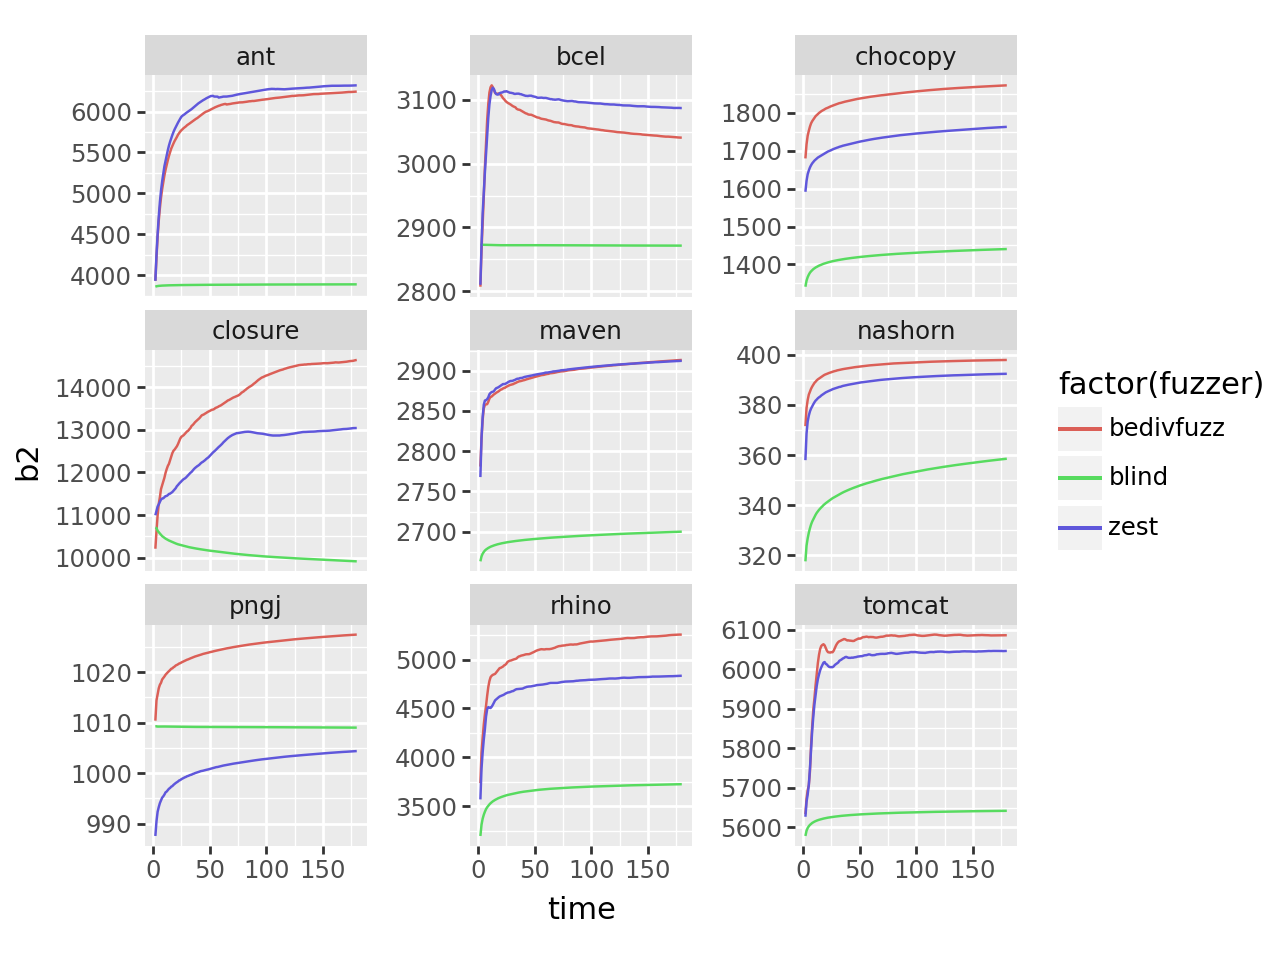

In [24]:
(ggplot(mean_trials.reset_index().query("time > 1"), aes("time", "b2", color="factor(fuzzer)"))
 + geom_line()
 + facet_wrap("~subject", scales="free_y")
 + theme(aspect_ratio = 1.0)
)

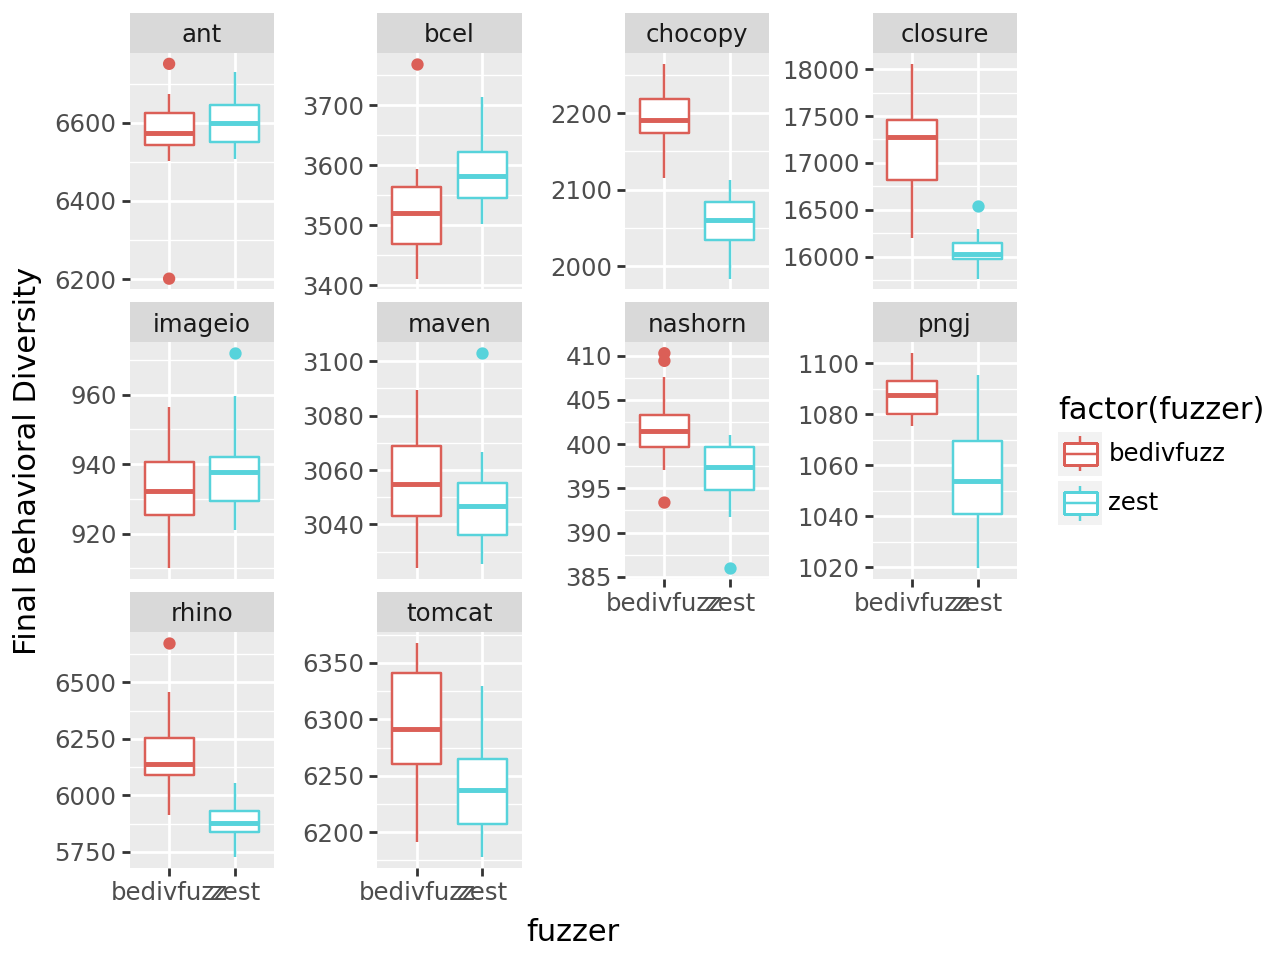

In [63]:
final_scores = trials.loc[trials['time'] == 180]

(ggplot(final_scores, aes("fuzzer", "b1", color="factor(fuzzer)"))
 + geom_boxplot()
 + facet_wrap("~subject", scales="free_y")
 + ylab("Final Behavioral Diversity")
)

In [31]:
trials.loc[trials['time'] == 180]

,fuzzer,subject,trial,time,b0,b1,b2
3585,zest,ant,1,180,10410.0,6693.30,6397.44
3585,zest,ant,2,180,10400.0,6730.58,6511.89
3586,zest,ant,3,180,10384.0,6550.98,6260.45
3586,zest,ant,4,180,10385.0,6506.47,6207.19
3566,zest,ant,5,180,11001.0,6554.19,6261.28
...,...,...,...,...,...,...,...
3605,bedivfuzz,tomcat,16,180,9396.0,6286.57,6085.37
3606,bedivfuzz,tomcat,17,180,9380.0,6301.22,6106.43
3603,bedivfuzz,tomcat,18,180,9406.0,6352.68,6146.13
3602,bedivfuzz,tomcat,19,180,9342.0,6344.74,6150.90


In [25]:
import scipy.stats as stats

In [30]:
metric = 'b0'
alpha = 0.01
time = 180
for s in subjects:
    x = trials.query(f"fuzzer == 'zest' and subject == '{s}' and time == {time}")[metric].to_numpy()
    y = trials.query(f"fuzzer == 'bedivfuzz' and subject == '{s}' and time == {time}")[metric].to_numpy()

    if stats.mannwhitneyu(x, y, alternative='two-sided').pvalue < alpha:
        print(f"{s.ljust(10)}: {'zest' if np.mean(x) > np.mean(y) else 'bedivfuzz'}")
    else:
        print(f"{s.ljust(10)}: not significant")


ant       : not significant
bcel      : not significant
chocopy   : not significant
closure   : zest
maven     : not significant
nashorn   : bedivfuzz
pngj      : bedivfuzz
rhino     : bedivfuzz
tomcat    : not significant


In [56]:
import math

crash_to_id = {}
def deduplicate_crash(exception_class, stack_trace):
    key = (exception_class, '-'.join(str(stack_trace).split('-')[:3]))
    key = exception_class
    if str(exception_class) == 'nan' or "OutOfMemoryError" in str(exception_class):
        return -1
    if key in crash_to_id.keys():
        return crash_to_id[key]
    else:
        crash_id = len(crash_to_id)
        crash_to_id[key] = crash_id
        return crash_id

In [57]:
def crash_trial_df(fuzzer: str, subject: str, trial: int):
    df = pd.read_csv(
        os.path.join(results_base_dir, fuzzer, subject, f'trial-1', 'failure_info.csv'),
        skipinitialspace=True
    )

    df['trial'] = trial
    df['fuzzer'] = fuzzer
    df['subject'] = subject
    df['crash_id'] = df.apply(lambda row: deduplicate_crash(row['exception_class'], row['top5_stack_trace']), axis=1)

    return df[['fuzzer', 'subject', 'trial', '# ttd', 'exception_class', 'crash_id']]

In [58]:
crash_dfs = []
for f, s, t in itertools.product(fuzzers, subjects, range(1, num_trials+1)):
    crash_dfs.append(crash_trial_df(fuzzer=f, subject=s, trial=t))
crash_trials = pd.concat(crash_dfs)

In [70]:
crash_trials = crash_trials.loc[crash_trials['crash_id'] != -1]

In [71]:
crash_trials.groupby(['subject', 'fuzzer'])['# ttd'].agg('median').round(0).astype(int)

subject  fuzzer   
bcel     bedivfuzz     698124
closure  bedivfuzz    4589495
         blind        4063835
         zest         3455229
rhino    bedivfuzz    2616056
         blind        4118536
         zest         4590806
Name: # ttd, dtype: int64

In [72]:
crash_trials.groupby(['subject', 'fuzzer'])['crash_id'].agg('nunique')

subject  fuzzer   
bcel     bedivfuzz    1
closure  bedivfuzz    1
         blind        1
         zest         2
rhino    bedivfuzz    2
         blind        3
         zest         4
Name: crash_id, dtype: int64

In [73]:
# Deduplicate bugs
crash_trials.groupby(['subject', 'fuzzer', 'trial', 'crash_id'])['# ttd'].agg('min')\
    .groupby(['subject', 'fuzzer']).agg('mean').round(0).astype(int)

subject  fuzzer   
bcel     bedivfuzz      62618
closure  bedivfuzz       7776
         blind          11987
         zest         3871169
rhino    bedivfuzz     162413
         blind        1367885
         zest          670867
Name: # ttd, dtype: int64

In [74]:
crash_to_id

{'class java.lang.NullPointerException': 0,
 'class java.lang.RuntimeException': 1,
 'class java.lang.IllegalStateException': 2,
 'class java.lang.VerifyError': 3,
 'class java.lang.ClassCastException': 4,
 'class org.apache.bcel.verifier.exc.AssertionViolatedException': 5}

In [75]:
crash_trials.groupby(['subject', 'fuzzer'])['crash_id'].unique()

subject  fuzzer   
bcel     bedivfuzz                   [5.0]
closure  bedivfuzz                   [0.0]
         blind                       [0.0]
         zest                   [0.0, 1.0]
rhino    bedivfuzz              [2.0, 0.0]
         blind             [2.0, 0.0, 3.0]
         zest         [2.0, 0.0, 3.0, 4.0]
Name: crash_id, dtype: object

In [80]:
crash_trials.groupby(['subject', 'fuzzer', 'trial', 'crash_id'])['# ttd'].agg('min')\
   .groupby(['subject', 'fuzzer', 'crash_id']).agg('count')

subject  fuzzer     crash_id
bcel     bedivfuzz  5.0         20
closure  bedivfuzz  0.0         20
         blind      0.0         20
         zest       0.0         20
                    1.0         20
rhino    bedivfuzz  0.0         20
                    2.0         20
         blind      0.0         20
                    2.0         20
                    3.0         20
         zest       0.0         20
                    2.0         20
                    3.0         20
                    4.0         20
Name: # ttd, dtype: int64